# Infinite Impulse Response (IIR) Systems

A system with infinite impulse response (IIR) is called an IIR system. It is described by the following difference equation:

$$
\begin{split}
y[n] 
&= x[n] - a_1 y[n-1] - a_2 y[n-2] - \cdots - a_M y[n-M] \\
&= x[n] - \sum_{k=1}^{M} a_k y[n-k]
\end{split}
$$

where $a_1, \dots, a_M$ are the system coefficients. Each output sample $y[n]$ is a weighted sum of the past output samples $y[n-1], \dots, y[n-M]$ and the current input sample $x[n]$. It is also called recursive system because the output samples are recursively computed from past output samples.

If we convert the equation to only have input samples on the right-hand side, we obtain

$$
\begin{align}
y[n] &= x[n] + \sum_{k=1}^{\infty} h_k x[n-k],\\
h_k &= \sum_{i=1}^k \sum_{q \in Q_k^i} \prod_{j=1}^i -a_{q_j}, \\
Q_k^i &= \{q \in \mathbb{Z}_{>0}^i \mid \sum_{j=1}^i q_j = k\}.
\end{align}
$$

The last two equations are ugly but thankfully we will not need them in this notebook. They are only included for completeness. You can see that the output samples $y[n]$ are a weighted sum of the current and past input samples $x[n], x[n-1], \dots$, just like in the FIR case. However, the length of the impulse response is infinite, hence the name IIR.

IIRs are very useful because you can approximate long FIRs with much less number of coefficients in an IIR. This also implies that they are cheaper to compute.

## Naive IIR Implementation in PyTorch

IIR is a linear system so it is differentiable everywhere. Let us first implement it in PyTorch using the above equation directly and see how it performs. 


In [174]:
import torch
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
from torchaudio.functional import lfilter
from timeit import timeit
from torch.profiler import profile, record_function, ProfilerActivity

In [190]:
def naive_iir(x: torch.Tensor, a: torch.Tensor):
    """
    Naive implementation of IIR filter.
    """
    assert x.ndim == 1
    assert a.ndim == 1
    T = x.numel()
    M = a.numel()

    # apply initial rest condition
    y = [x.new_zeros(1)] * M
    for i in range(T):
        past_outputs = torch.cat(y[-1:-M-1:-1])
        y.append(x[i:i+1] -torch.dot(a, past_outputs))
    return torch.cat(y[M:])

For simplicity, the above implementation assumes for $n < 0$, $y[n]$ are always zeros. Let us check whether the implementation is correct by comparing it with the `scipy.signal.lfilter` function.

The test signal is a chirp signal with a frequency that increases linearly from 5 Hz to 100 Hz in 1 second. The sampling rate is 16000 Hz.

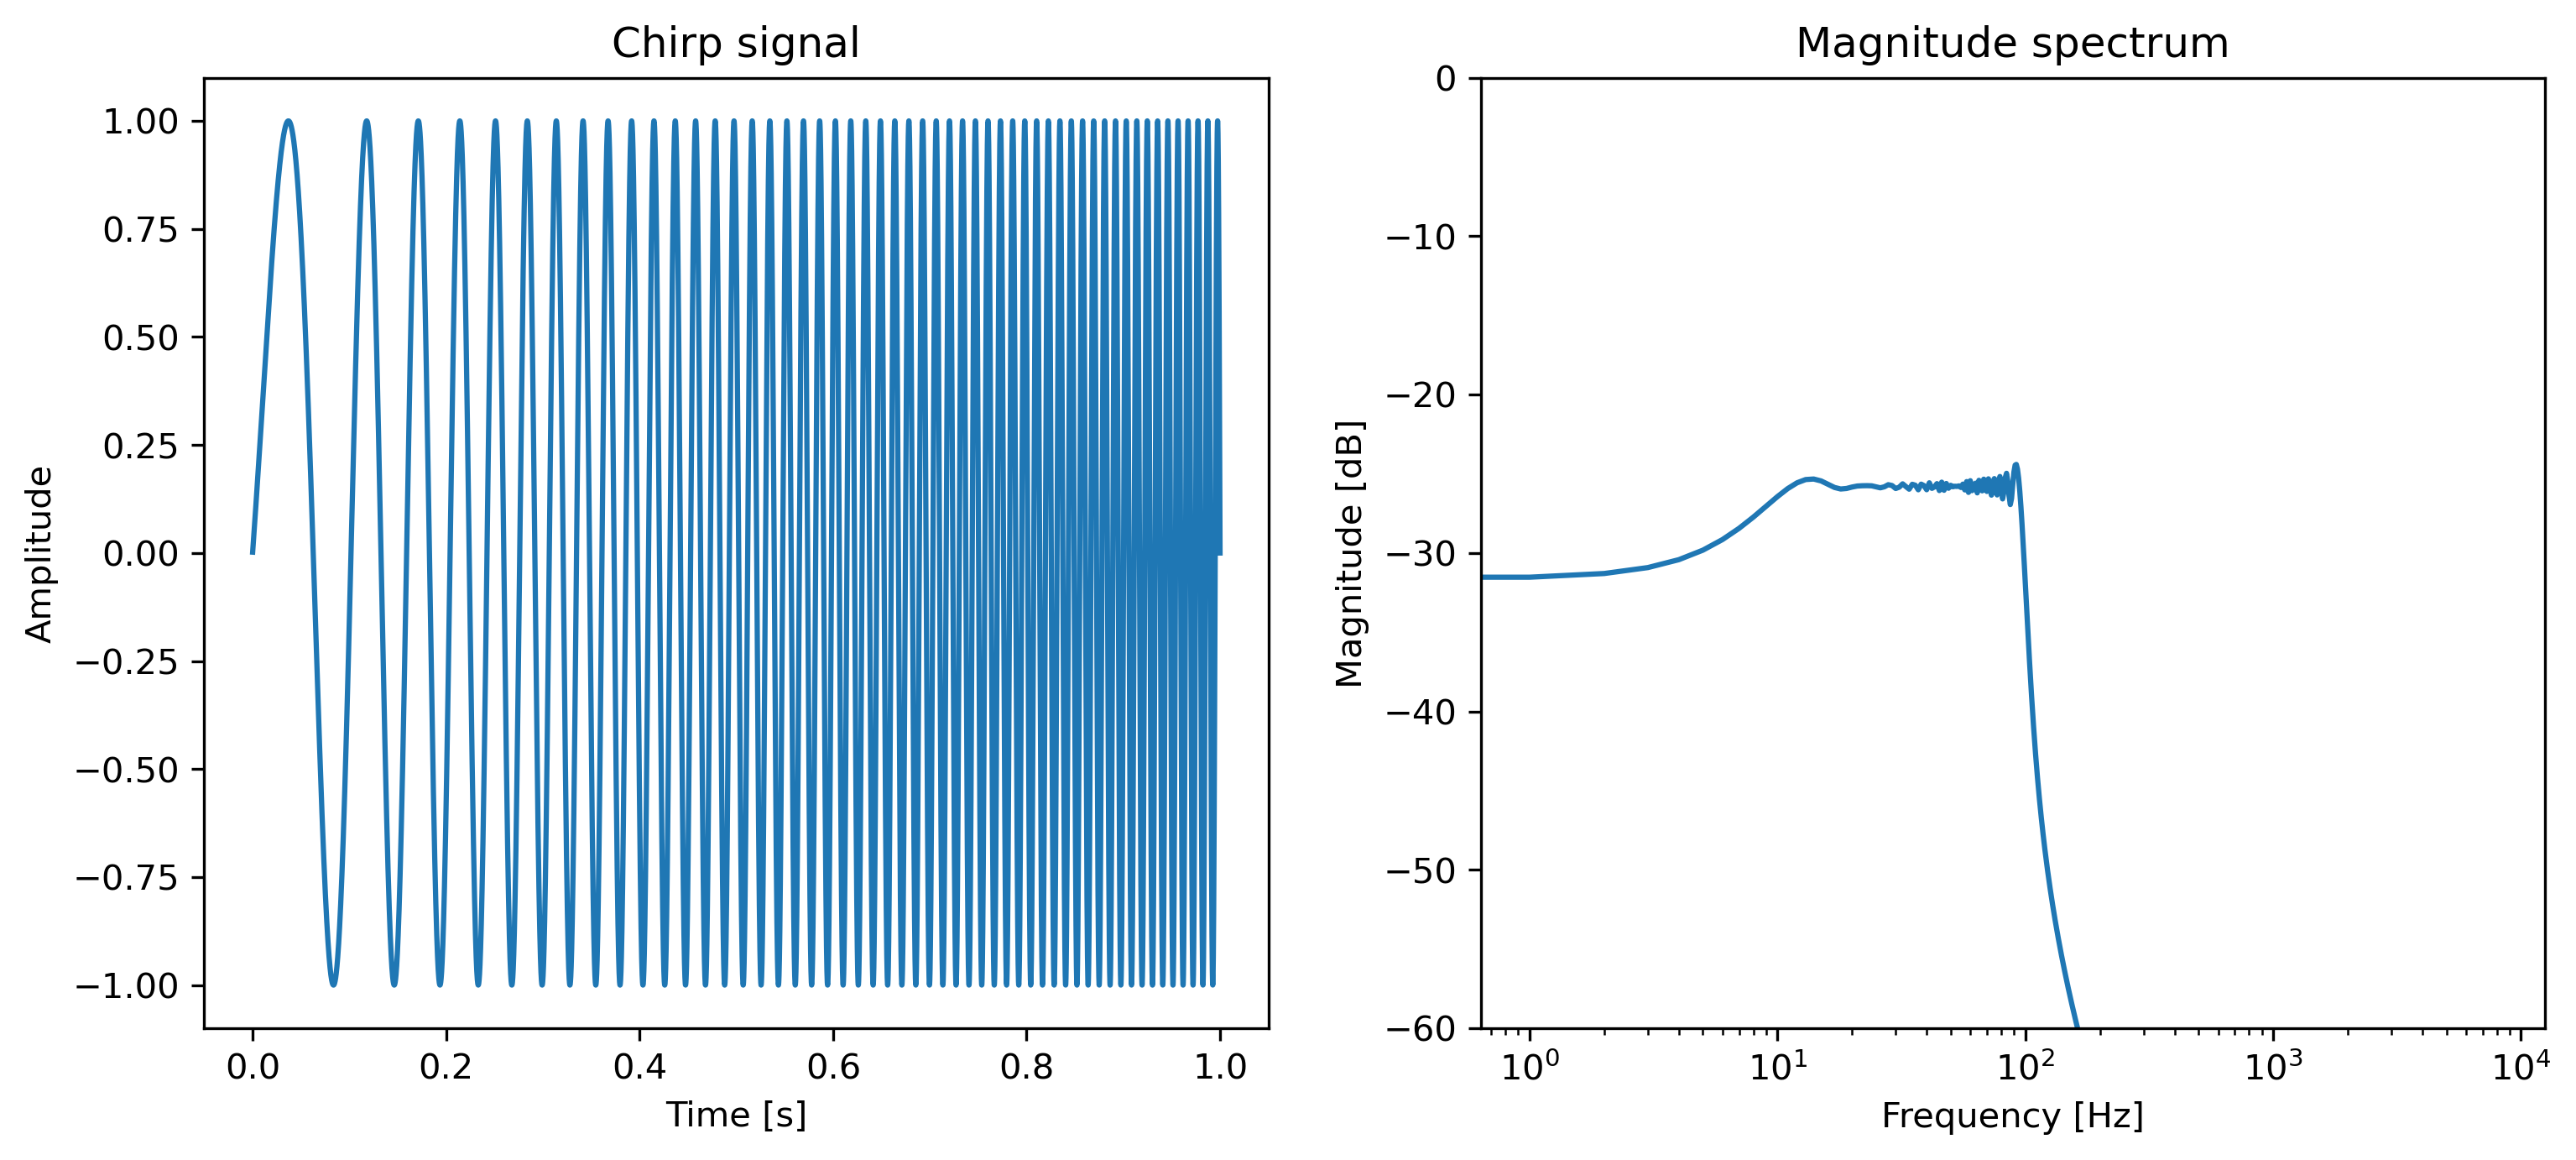

In [34]:
def chirp(T: int, start_freq: float, end_freq: float, fs: float):
    """
    Generate chirp signal.
    """
    angular_freq = np.linspace(start_freq, end_freq, T) / fs
    phase = np.cumsum(angular_freq)
    return np.sin(2 * np.pi * phase)

fs = 16000
T = 16000
start_freq = 5
end_freq = 100
test_signal = chirp(T, start_freq, end_freq, fs)

fig = plt.figure(figsize=(12, 5), dpi=300)
plt.subplot(1, 2, 1)
plt.plot(np.arange(T) / fs, test_signal)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Chirp signal")
plt.subplot(1, 2, 2)
plt.magnitude_spectrum(test_signal, Fs=fs, scale='dB', window=signal.windows.boxcar(T))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.xscale("log")
plt.ylim(-60, 0)
plt.title("Magnitude spectrum")
plt.show()

The filter we use is a second-order IIR ($M$ = 2) with coefficients $a_1 = -1.8$ and $a_2 = 0.8$. Let us see how the filter performs on the chirp signal.

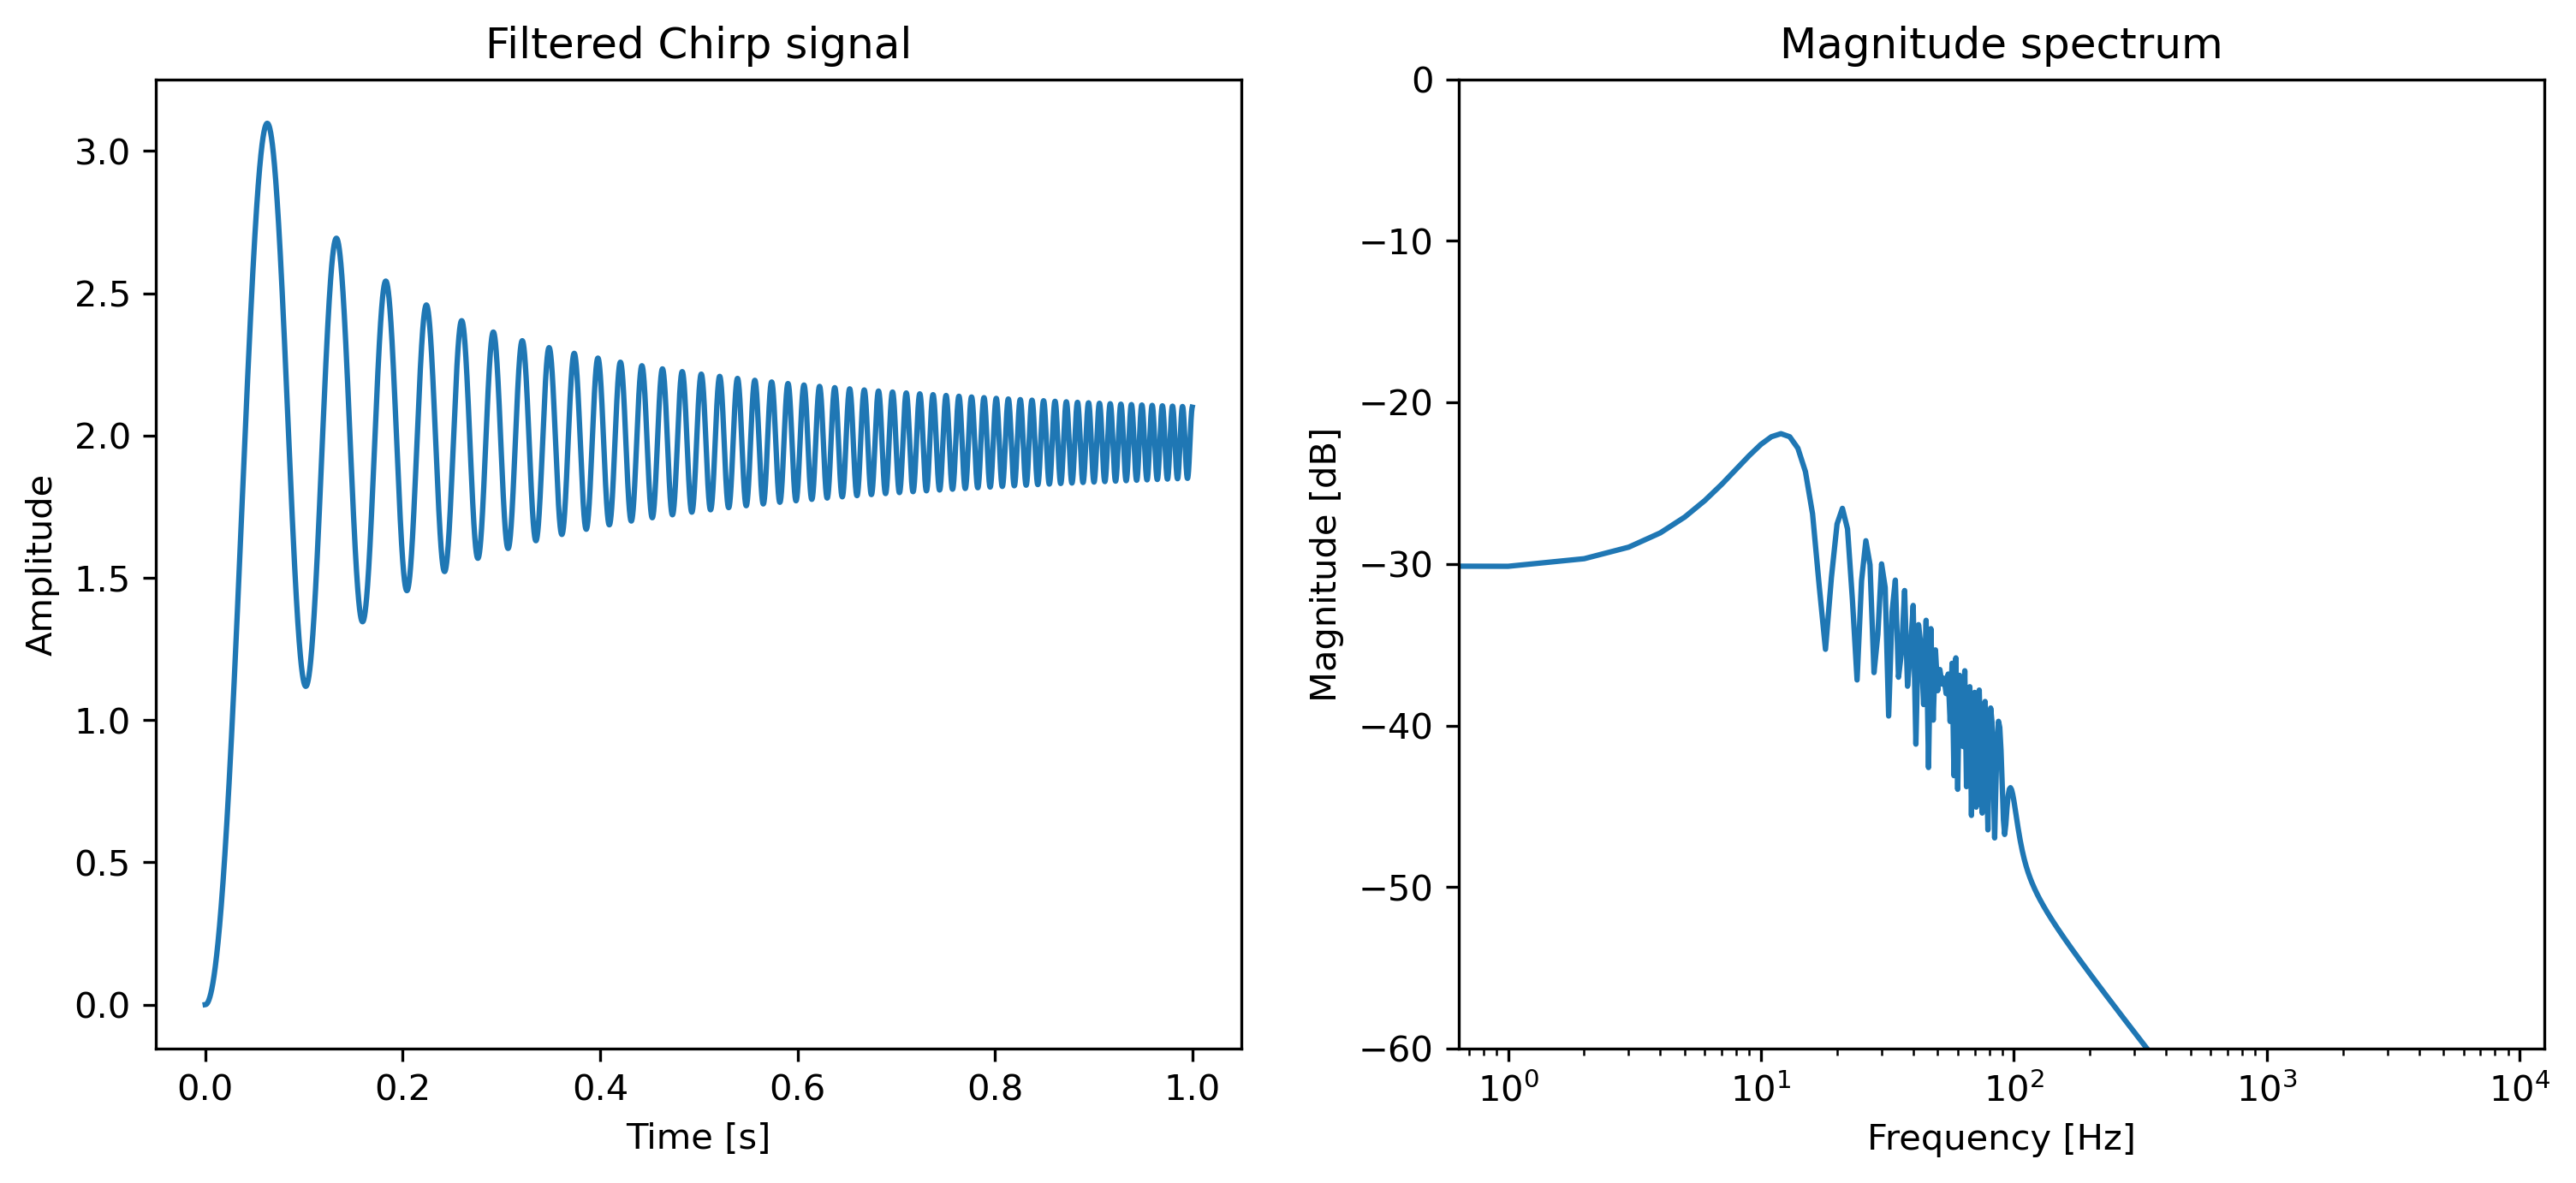

In [162]:
# b, a = signal.iirfilter(2, 50 / fs * 2, btype='lowpass', analog=False, ftype='butter', output='ba')
# print("b:", b)
# print("a:", a)
b = [1e-3, 0, 0]
a = [1, -1.8, 0.8]
filtered_signal = signal.lfilter(b, a, test_signal)

fig = plt.figure(figsize=(12, 5), dpi=300)
plt.subplot(1, 2, 1)
plt.plot(np.arange(T) / fs, filtered_signal)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Filtered Chirp signal")
plt.subplot(1, 2, 2)
plt.magnitude_spectrum(filtered_signal, Fs=fs, scale='dB', window=signal.windows.boxcar(T))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.xscale("log")
plt.ylim(-60, 0)
plt.title("Magnitude spectrum")
plt.show()

Is our PyTorch implementation correct? Let us compare it with the `scipy.signal.lfilter` function.

In [191]:
a_torch = torch.tensor(a[1:], dtype=torch.float64)
filtered_signal_torch = naive_iir(torch.from_numpy(test_signal[:]) * b[0], a_torch)

assert torch.allclose(filtered_signal_torch, torch.from_numpy(filtered_signal[:]))

Horay! It pass the test. Let us now see how fast it is.

In [226]:
scipy_time = timeit(
    stmt="signal.lfilter(b, a, test_signal)", setup="from scipy import signal", 
    globals={
        "b": b,
        "a": a,
        "test_signal": test_signal
    },
    number=1000
) / 1000

torch_time = timeit(
    stmt="naive_iir(test_signal_torch, a_torch)",
    globals={
        "a_torch": a_torch,
        "test_signal_torch": torch.from_numpy(test_signal) * b[0],
        "naive_iir": naive_iir
    },
    number=10
) / 10

print(f"scipy.signal.lfilter: {scipy_time:.4f} [s]")
print(f"naive_iir: {torch_time:.4f} [s]")

scipy.signal.lfilter: 0.0001 [s]
naive_iir: 0.1818 [s]


The direct implementation is >1000 times slower than the `scipy.signal.lfilter` function! What is the reason? One reason is that the core part of `scipy.signal.lfilter` is implemented in C and is highly optimised. Let us use `torch.profiler` to profile the code and see if we can make our implementation faster.



<!-- 
To make our implementation faster, let us look into the for-loop of `naive_iir` function.

We have four tensor operations in each loop, which are:
1. Concatenating the past output samples (`torch.cat(y[-1:-M-1:-1])`)
2. Multiplying the past output samples with the coefficients (`a @ past_outputs`)
3. Subtracting the result from the current input sample (`x[n] - a @ past_outputs`)
Each of these operations create a tensor -->

In [227]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    naive_iir(torch.from_numpy(test_signal) * b[0], a_torch)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

--------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
--------------------  ------------  ------------  ------------  ------------  ------------  ------------  
           aten::dot        30.94%      34.703ms        32.20%      36.120ms       2.257us         16000  
         aten::slice        30.42%      34.118ms        30.59%      34.311ms       2.144us         16000  
           aten::cat        19.51%      21.888ms        19.51%      21.888ms       1.368us         16001  
           aten::sub        17.62%      19.764ms        17.62%      19.764ms       1.235us         16000  
         aten::empty         1.27%       1.426ms         1.27%       1.426ms       0.089us         16001  
    aten::as_strided         0.17%     195.000us         0.17%     195.000us       0.012us         16000  
           aten::mul         0.03%   

The above table shows that a lot of CPU time were spent on `aten:sub`, `aten::cat`, and `aten::dot`. These operations are not optimized for small tensors, but we call them in each loop. In addition, each operation creates a new tensor, and with more than ten thousands of loops, the memory allocations becomes a bottleneck. We recommend readers to check [issue 1238](https://github.com/pytorch/audio/issues/1238) of TorchAudio for more details.

One thing we can do is to first allocate a tensor for all the past output samples and reuse it in each loop. This will reduce the number of memory allocations. We can also utilise the `torch.jit.script` decorator to utilise the just-in-time compilation of PyTorch. This will reduce the overhead of Python interpreter. Let us see how much faster it is.

In [252]:
@torch.jit.script
def inplace_iir(x: torch.Tensor, a: torch.Tensor):
    """
    Inplace implementation of IIR filter.
    """
    assert x.ndim == 1
    assert a.ndim == 1
    T = x.numel()
    M = a.numel()

    # allocate memory for output
    y = x.new_zeros(M + T)
    y[M:] = x
    a_flip = a.flip(0)
    for i in range(T):
        past_outputs = y[i:i+M]
        y[i+M] -= torch.dot(a_flip, past_outputs)
    return y[M:]

In [254]:
assert torch.allclose(inplace_iir(torch.from_numpy(test_signal[:]) * b[0], a_torch), torch.from_numpy(filtered_signal[:]))

torch_time = timeit(
    stmt="iir(test_signal_torch, a_torch)",
    globals={
        "a_torch": a_torch,
        "test_signal_torch": torch.from_numpy(test_signal) * b[0],
        "iir": inplace_iir
    },
    number=10
) / 10

print(f"inplace_iir: {torch_time:.4f} [s]")

inplace_iir: 0.0776 [s]


We reduce around 60% of the CPU time! However, it is still much slower than the scipy counterpart. The remaining time are mostly related to the framework overhead and cannot be further reduced using the Python frontend.

## References